## Plot Figures 1-4

These depict the input data , preprocessing, SpecUFEx workflow

For Sawi et al., 2021

In [1]:
import os

import sys


import h5py

import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

from matplotlib import cm

import matplotlib.gridspec as gridspec

import matplotlib.image as mpimg

from scipy.io import loadmat


import datetime as dtt

import datetime




sys.path.append('.')
sys.path.append('../src/visualization/')

import paths



from functions2 import dateToEventID, getDailyTempDiff, getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram,PCAonFP,calcSilhScore,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat,calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2



In [2]:


from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat 
from functions2 import catMergeFromH5, swapLabels, calcFFT, getWF, swapLabels,trimSpectra, KMeansSpectra, compileSpectraFromWF
import figureFunctions2

## Set paths

In [3]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
filetypeN = '.sac' 


p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
path_WF         = p['path_WF']
path_Cat        = p['path_Cat'] #original, raw catalog
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'
pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


# pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station          = pN['station']
channel          = pN['channel']


path_top         = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
path_WFN         = pN['path_WF']
path_CatN        = pN['path_Cat'] #original, raw catalog
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'
pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN        = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'
pathWN           = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 



# pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN


pathFig = '../reports/figures/'
pathAuxData = '../data/processed/Garcia/'

## Load auxiliary catalog

In [4]:
## Load auxiliary catalog

gps_station_list = ['24','34','36','37']
gps_df_list = []

for gst in gps_station_list:
    
    
    gps_df = pd.read_csv(f'{pathAuxData}gps_roll_Slopecorrected_{gst}.csv',index_col=0)
    gps_df['datetime'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df['datetime_index'] = [pd.to_datetime(ii) for ii in gps_df.index]
    gps_df = gps_df.set_index('datetime_index')
    
    
    gps_df_list.append(gps_df)


lake_df = pd.read_csv(f'{pathAuxData}lake_df.csv',index_col=0)
lake_df['datetime'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df['datetime_index'] = [pd.to_datetime(ii) for ii in lake_df.index]
lake_df = lake_df.set_index('datetime_index')


meteor_df = pd.read_csv(f'{pathAuxData}meteor_df.csv',index_col=0)
meteor_df['datetime'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df['datetime_index'] = [pd.to_datetime(ii) for ii in meteor_df.index]
meteor_df = meteor_df.set_index('datetime_index')

rain_df = meteor_df.rain


## Define some important times in study period

In [5]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)


## Load original catalogs

In [6]:
cat00 = catMergeFromH5(path_Cat,path_proj,outfile_name)
cat00N = catMergeFromH5(path_CatN,path_projN,outfile_nameN)

1411 events kept, merge sucessful
1521 events kept, merge sucessful


## Load station data

In [7]:
##station data 
stn = pd.read_csv("../data/raw/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
     

## Get experiment parameters from H5 file

In [8]:
#########       #########       #########       #########       #########       #########       #########       #########       

####IQIQIQIQIQIQIQIQI

#########       #########       #########       #########       #########       #########       #########       #########       



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)


#########       #########       #########       #########       #########       #########       #########       #########       

##### NOISENOISENOISENOISENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)



## Load specufex output

In [9]:

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - IQIQIQIQIQIQIQIQIQIQ
 
#########       #########       #########       #########       #########       #########       #########       #########       Wmat = loadmat(pathW)

## specufex parameters
Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]



order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

#########       #########       #########       #########       #########       #########       #########       #########       

## specufex output - NOISENOISENOINSENOISE

#########       #########       #########       #########       #########       #########       #########       #########       


WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]


order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

## Format day ticks, time plotting

* Central European Time is 2 hours later than UTC (Coordinated Universal Time) 
* Max temp occurs around 16:00 (4pm) local time or, 14:00 (2pm) UTC
* All times in UTC


todo: fix ::


##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat0.event_ID.resample('D', label='left', closed='right').count()

In [10]:


############################################################
            ##### FORMAT DAY TICKS (ASSUMES NO DAYS SKIPPED?) ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')



delta_day = 7

##dummy variable -- just needed to get complete day set -- FIXFIX
clus_clu_perday = cat00.event_ID.resample('D', label='left', closed='right').count()

numDays = len(clus_clu_perday)

days_list = [clus_clu_perday.index[i] for i in range(numDays)]


## these have lots of possible text formats
day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
## start of

#all times in UTC
hour_of_approx_max_temp = 14
# hourMaxTemp = [dtt.datetime(2007, 6, 14,hour_of_approx_max_temp,0,0) + pd.DateOffset(i) for i in range(0,numDays)]


## ts 2021/08/07 : change line to start of day
dayStart = hourMaxTemp = [dtt.datetime(2007, 6, 14) + pd.DateOffset(i) for i in range(0,numDays)]

hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

       

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


In [11]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))


## when plotting, add a bit of buffer so bars aren't cut off
tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'colors':colors,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart, ## for extending x axis to fit bars
              'tend':tlimend,     ## for extending x axis to fit bars
              'tstartreal':tstart,## actual study bound
              'tendreal':tend     ## actual study bound
             }

## Specs for figures JGR

In [12]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

# Figure 1 - Icequake map with depth 

In [13]:
img = mpimg.imread('/Users/theresasawi/Documents/11_Manuscripts/Sawietal_2021/SawiEtAl_2021/data/external/GarciaEtAl_2019/map_CH.jpeg')


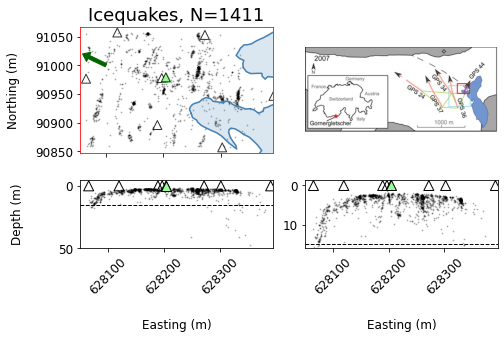

In [14]:
##v2
##settings for yellow bars
plt.rcParams.update({'font.size': 12})




fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(7,4)
gs.update(wspace=.4, hspace=0.07)

## Bar plot, Temp and Lake/Precip
ax = plt.subplot(gs[0:5,0:2])
for spine in ax.spines.values():
    spine.set_edgecolor('red')
    
    
figureFunctions2.plotMap(cat00,ax=ax,colorBy='all',size=1,alpha=.2,**plt_kwargs); #'cluster';'all';'datetime'
figureFunctions2.plotStations(stn,station,ax=ax)
buff = 10
ax.set_xlim(cat00.X_m.min()-buff,cat00.X_m.max()+buff)
ax.set_ylim(cat00.Y_m.min()-buff,cat00.Y_m.max()+buff)
ax.set_aspect('equal')
# ax.set_xticks([])
ax.set_xticklabels('')

ax.set_ylabel('Northing (m)',labelpad=15,fontsize=12)

title = f'Icequakes, N={len(cat00)}'    
ax.set_title(title, pad=6,fontsize=18) 


## flow arrow
x = 628100
y = 91000
dx = -60 / 2
dy = 29 / 2
ax.arrow(x, y, dx, dy,color='darkgreen',width=6,head_length=12)


# #### plot depth and stations 
ax2 = plt.subplot(gs[5:7,0:2])

figureFunctions2.plotDepth(cat00,stn,ax=ax2,byCluster=False,size=1,alpha=.2,stasize=100,**plt_kwargs)    
ax2.set_ylabel('Depth (m)',labelpad=34,fontsize=12)
# ax2.set_xlabel('                                            Easting (m)',labelpad=22,fontsize=12)
ax2.set_xlabel('Easting (m)',labelpad=22,fontsize=12)


ax2.set_ylim(50,-5)
# ax2.set_aspect('1.42')
# ax.text(628100,40,'VE=4',fontsize=10)
ax2.tick_params(axis='x',labelrotation=45)
ax2.axhline(15,color='k',ls='--',lw=1)

# #### plot depth and stations zoomed in
ax2 = plt.subplot(gs[5:7,2:])

figureFunctions2.plotDepth(cat00,stn,ax=ax2,byCluster=False,size=1,alpha=.2,stasize=100,**plt_kwargs)    
ax2.set_ylabel('')
ax2.set_xlabel('Easting (m)',labelpad=22,fontsize=12)

ax2.set_ylim(16,-1.5)
ax2.axhline(15,color='k',ls='--',lw=1)

# ax2.set_aspect('1.42')
# ax.text(628100,40,'VE=4',fontsize=10)
ax2.tick_params(axis='x',labelrotation=45)


ax2 = plt.subplot(gs[1:4,2:])

ax2.imshow(img)
ax2.axis('off')

plt.savefig(pathFig + f'Figure_1.png',bbox_inches='tight')


# Figure 2

## Choose examples based on mideseason, drainage, and post drainage times


In [15]:

loc_ids = [450,930,1350]
rand_date_list = [pd.to_datetime('200' + evID) for evID in cat00.event_ID.iloc[loc_ids]]
rand_date_listN = [pd.to_datetime('200' + evID) for evID in cat00N.event_ID.iloc[loc_ids]]

print(rand_date_list,rand_date_listN)


[Timestamp('2007-06-27 16:33:34'), Timestamp('2007-07-05 17:30:25'), Timestamp('2007-07-18 15:31:07')] [Timestamp('2007-06-27 16:48:42'), Timestamp('2007-07-09 08:15:27'), Timestamp('2007-07-18 19:22:58')]


In [16]:
dtf = pd.DateOffset(1) #offset pink labels above date bars
dailyTempDiff = getDailyTempDiff(meteor_df,**plt_kwargs)


../src/visualization/functions2.py:320: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_H = meteor_df1.temp.resample('H',loffset='30T').mean().ffill()
../src/visualization/functions2.py:321: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  temp_D = meteor_df1.temp.resample('D',loffset='12H').mean().ffill()


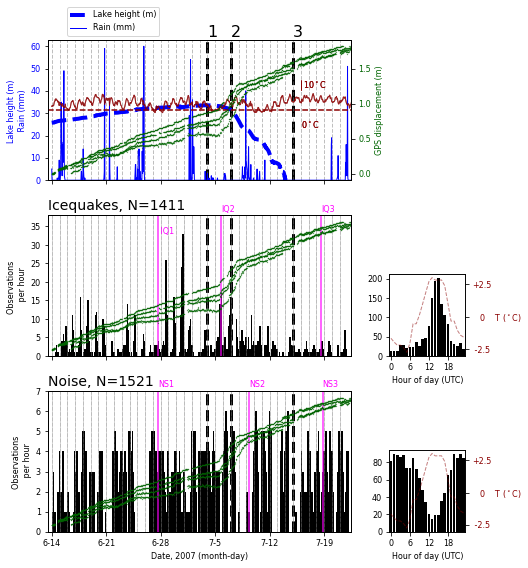

In [22]:
plt.figure(figsize=(width2,height2))
ax = plt.gca()

gs = gridspec.GridSpec(9,4)
gs.update(hspace=1.5,wspace=.5)

dtf = pd.DateOffset(0) #offset pink labels above date bars
Kopt=1

tpad = 5
tfont = 14

bW = .2

title = f'Icequakes, N={len(cat00)}'   
XX='IQ'#label for event line
ymax = 41
YY = 42
titleN = f'Noise, N={len(cat00N)}'
XXN='NS'#label for event line
ymaxN = 17
YYN = 18 

## Plot aux geophyscial data
ax = plt.subplot(gs[0:3,0:-1])


## lol 3 for alpha
figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)  
figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)   
figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)   

#lines for drainage
ax.axvline(supraDraint,color='k',ls='--',linewidth=3)
ax.axvline(subDraint,color='k',ls='--',linewidth=3)
ax.axvline(drainEndt,color='k',ls='--',linewidth=3)

#text for drainage
yy = 64
fonts = 16
ax.text(supraDraint,yy,'1',color='k',fontsize=fonts)
ax.text(subDraint,yy,'2',color='k',fontsize=fonts)
ax.text(drainEndt,yy,'3',color='k',fontsize=fonts)

#day lines
for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='gray',linestyle='--',linewidth=1,alpha=.5)

    

# lake and rain
# figureFunctions2.plotLake(lake_df,rain_df,legend=False,bb1=0,bb2=0,ylabel='left',ax=ax,**plt_kwargs)
label='Lake height (m)'
labelR = 'Rain (mm)'
ax.set_ylabel('Lake height (m) \n Rain (mm) ',color='b')
ax.set_yticks(np.arange(0,61,10))
ax.set_yticklabels([f'{a:.0f}' for a in np.arange(0,61,10)])
[t.set_color('b') for t in ax.yaxis.get_ticklabels()]
ax.plot(lake_df.lake,c='b',lw=4,ls='--',label=label)

rain10 = rain_df * 10 #convert cm to mm
ax.plot(rain10,c='b',label=labelR,lw=1)
ax.set_xticks(day_ticks)
ax.set_xticklabels(day_labels)













ax.legend(bbox_to_anchor=(.05,1))













ax.set_xlabel('')
ax.set_xlim(tstart,tend)


#gps displ
for i, gps_dff in enumerate(gps_df_list):
    if i==0:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ax=ax,**plt_kwargs)
    else:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ylabel='none',ax=ax,**plt_kwargs)


ax.set_xlabel('')   
ax.set_xticklabels('')   

ax.set_ylim(ymin=0)



### ### ### ICEQUAKES ### ### ### 
### ### ### ICEQUAKES ### ### ### 
### ### ### ICEQUAKES ### ### ### 
### ### ### ICEQUAKES ### ### ### 
### ### ### ICEQUAKES ### ### ### 



## Bar plot, Temp and Lake/Precip
ax = plt.subplot(gs[3:6,0:-1])

#lines for drainage
ax.axvline(supraDraint,color='k',ls='--',linewidth=3)
ax.axvline(subDraint,color='k',ls='--',linewidth=3)
ax.axvline(drainEndt,color='k',ls='--',linewidth=3)

# ax.set_ylim(0,ymax)
ax.set_xlabel('Date, 2007 (month-day)',labelpad=6)
ax.set_xlim(tstart,tend)

figureFunctions2.plotBar(cat00,Kopt,barWidth=bW,timeBin='H',byCluster=False,ax=ax,**plt_kwargs)

# figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)   

# figureFunctions2.plotLake(lake_df,rain_df,legend=False,ylabel='none',ax=ax,**plt_kwargs)
#gps displ
for i, gps_dff in enumerate(gps_df_list):
    if i==0:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ylabel='none',ax=ax,**plt_kwargs)
    else:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ylabel='none',ax=ax,**plt_kwargs)

for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='gray',linestyle='--',linewidth=1,alpha=0.3) 

    YY = 39
###plot bars where sgrams were sampled
for i, da in enumerate(rand_date_list):
    if i==0:
        ax.text(da - dtf,33,f' {XX}{i+1}',color='fuchsia')#,rotation=90)
    else:
        ax.text(da - dtf,YY,f'{XX}{i+1}',color='fuchsia')#,rotation=90)
        
    ax.axvline(da,c='fuchsia',linestyle='-',linewidth=1.5,alpha=.8) 
    

ax.set_title(title, pad=tpad,fontsize=tfont,loc='left')
ax.set_xlabel('')   
ax.set_xticklabels('')   
ax.set_ylim(0,38)

    
### ### ### NOISE ### ### ### 
### ### ### NOISE ### ### ### 
### ### ### NOISE ### ### ### 
### ### ### NOISE ### ### ### 
### ### ### NOISE ### ### ### 

## Bar plot, Temp and Lake/Precip
ax = plt.subplot(gs[6:9,0:-1])

#gps displ
for i, gps_dff in enumerate(gps_df_list):
    if i==0:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ax=ax,ylabel='none',**plt_kwargs)
    else:
        figureFunctions2.plotGPS(gps_dff.gps_roll,size=.5,ylabel='none',ax=ax,**plt_kwargs)

# ax.set_ylim(0,ymaxN)
ax.set_xlabel('Date, 2007 (month-day)',labelpad=4)
ax.set_xlim(tstart,tend)



#lines for drainage
ax.axvline(supraDraint,color='k',ls='--',linewidth=3)
ax.axvline(subDraint,color='k',ls='--',linewidth=3)
ax.axvline(drainEndt,color='k',ls='--',linewidth=3)

figureFunctions2.plotBar(cat00N,1,barWidth=bW,timeBin='H',byCluster=False,ax=ax,**plt_kwargs)

# figureFunctions2.plotTemp(meteor_df.temp,ax=ax,**plt_kwargs)   

# figureFunctions2.plotLake(lake_df,rain_df,legend=False,ylabel='none',ax=ax,**plt_kwargs)


for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='gray',linestyle='--',linewidth=1,alpha=0.3) 

YYN = 7.2 
###plot bars where sgrams were sampled
for i, da in enumerate(rand_date_listN):
    
    ax.axvline(da,c='fuchsia',linestyle='-',linewidth=1.5,alpha=.8) 
    ax.text(da - dtf,YYN,f'{XXN}{i+1}',color='fuchsia')#,rotation=90)
    
ax.set_title(titleN, pad=tpad,fontsize=tfont,loc='left')

ax.set_ylim(0,7)



#### HOURHOURHOURHOUR #####
#### HOURHOURHOURHOUR #####
#### HOURHOURHOURHOUR #####
#### HOURHOURHOURHOUR #####
#### HOURHOURHOURHOUR #####
#### HOURHOURHOURHOUR #####
#### HOURHOURHOURHOUR ######### HOURHOURHOURHOUR ######### HOURHOURHOURHOUR #####




ax = plt.subplot(gs[4:6,-1])
figureFunctions2.plotHourBar(cat00,1,dailyTempDiff,ax=ax,labelpad=10,**plt_kwargs)
# ax.set_xlabel('')
# ax.set_xticklabels('')
ax.set_xlabel('Hour of day (UTC)')

# ax.set_ylabel('Number of observations                                 ',labelpad=0)






ax = plt.subplot(gs[7:9,-1])
#plot Bars
figureFunctions2.plotHourBar(cat00N,1,dailyTempDiff,ax=ax,labelpad=10,**plt_kwargs)
ax.set_xlabel('Hour of day (UTC)')



plt.savefig(pathFig + f'Figure_2.png',bbox_inches='tight')



## Figure 3 

* Calc full (0-500Hz) means for all spectra


In [18]:
calcSpectra = 1
if calcSpectra:
    list_rand_specMatsum = []
#     for j,evID in enumerate(cat00.event_ID.iloc[0:5]):
    for j,evID in enumerate(cat00.event_ID):
        try:
            specMatsum,specMat,fSTFT2 = getSpectra_fromWF(int(evID),dataH5_path,station,channel,normed=True)

            if j == 0:
                specMatsum_sum = np.zeros(len(specMatsum))
                specMatsum_med = np.zeros(len(specMatsum))

            ax.plot(fSTFT2,specMatsum,alpha=.01,c='darkgray')


            specMatsum_sum += specMatsum

            specMatsum_med = np.vstack([specMatsum_med,specMatsum])
        except:
            continue




    print(j+1)
    specMatsum_mean = specMatsum_sum / (j+1)
    specMatsum_med = np.median(specMatsum_med,axis=0)
    sstd = np.std(specMatsum_med,axis=0)



    list_rand_specMatsumN = []
#     for j,evID in enumerate(cat00N.event_ID.iloc[0:5]):
    for jN,evID in enumerate(cat00N.event_ID):
        
        try:
            specMatsumN,specMatN,fSTFT2N = getSpectra_fromWF(evID,dataH5_pathN,station,channel,normed=True)

            if jN == 0:
                specMatsum_sumN = np.zeros(len(specMatsumN))
                specMatsum_medN = np.zeros(len(specMatsumN))

            ax.plot(fSTFT2N,specMatsumN,alpha=.01,c='darkgray')


            specMatsum_sumN += specMatsumN

            specMatsum_medN = np.vstack([specMatsum_medN,specMatsumN])
        except:
            continue

    print(jN+1)
    specMatsum_meanN = specMatsum_sumN / (jN+1)
    specMatsum_medN = np.median(specMatsum_medN,axis=0)
    sstdN = np.std(specMatsum_medN,axis=0)



1411
1521


* plot

In [19]:
def figureFunctions2plotSgram(specMat,evID,tSTFT, fSTFT,cbarMax,cbarLabel='',ax=None):
    #set x to datetime list or seconds in tSTFT
    # x=tSTFT
    if ax is None:
        ax = plt.gca()

    plt.pcolormesh(tSTFT, fSTFT, specMat,cmap=cm.magma, shading='auto')

    cbar = plt.colorbar(pad=.06)
    cbar.set_label(cbarLabel)
    
    
    plt.clim(0,cbarMax)## sprectrograms are nonnegative
    date_title = str(pd.to_datetime('200' + evID))
    ax.set_title(date_title,pad=10)






    plt.ylabel('f (Hz)',labelpad=10)
    plt.xlabel('t (s)')


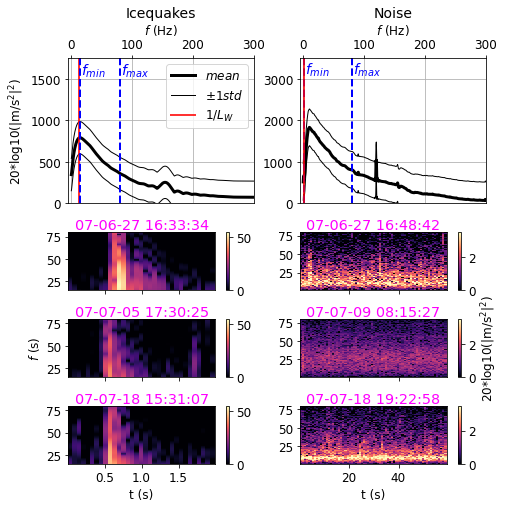

In [23]:
if calcSpectra:
    plt.rcParams.update({'font.size': 12})


    fig,axes = plt.subplots(figsize = (width2,height1*2))#,sharex=True,constrained_layout=True)
    gs = gridspec.GridSpec(6, 6)
    gs.update(wspace=1.5, hspace=.5)


    flabel1 = 1550
    flabel1N = 3120
    FS = 14#font size for fmin and fmax
    ymax = 1750
    ymaxN = 3500

    ## Bar plot, Temp and Lake/Precip
    ax = plt.subplot(gs[0:2,0:3])

    ax.set_ylabel('20*log10(|m/s$^2$|$^2$)')

    ax.plot(fSTFT2,specMatsum_mean,c='k',label='$mean$',lw=3)
    ax.plot(fSTFT2,specMatsum_mean+sstd,c='k',label='$\pm1 std$',lw=1)
    ax.plot(fSTFT2,specMatsum_mean-sstd,c='k',lw=1)

    ax.axvline(x=1/winLen_Sec,color='r',label='$1/L_{W}$',lw=2,alpha=.8)  


    ax.axvline(x=fmin,color='blue',ls='--',lw=2)
    ax.axvline(x=fmax,color='blue',ls='--',lw=2)
    ax.text(fmin+1, flabel1,'$f_{min}$',c='b',fontsize=FS)
    ax.text(fmax+1, flabel1,'$f_{max}$',c='b',fontsize=FS)


    ax.set_xlabel('$f$ (Hz)')
    ax.set_xlim(-5,300)
    ax.set_ylim(0,ymax)

    ax.legend(loc='upper right',bbox_to_anchor=(1,1))
    ax.set_title('Icequakes',pad=tpad,fontsize=tfont)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()
    plt.grid()


# loc_ids = [450,930,1350]

    for i, evID in enumerate(cat00.event_ID.iloc[loc_ids]):
        axs = plt.subplot(gs[i+2,0:3],ymargin=.1)
        
        cbarMax = 55

        specMat,x = getSgram(path_proj,evID,station)
        figureFunctions2plotSgram(specMat,evID,tSTFT,fSTFT,ax=axs,cbarMax=cbarMax)#, **plt_kwargs)
        axs.set_xlabel('t (s)',labelpad=4)
        axs.set_ylabel('$f$ (s)',labelpad=4)

        datte = str(pd.to_datetime('200' + str(evID)).date())[2:]
        timme = str(pd.to_datetime('200' + str(evID)).time())
        plt.title(f'{datte} {timme}',color='fuchsia',pad=2)

        if i != 2:
    #         axs.set_xticks([]) 
            axs.set_xticklabels('')     
            axs.set_xlabel('')         
        if i != 1:
            axs.set_ylabel('')
    #         axs.set_yticklabels('')
    #         axs.set_yticks([]) 


    ###### NOISE #####

    ## Bar plot, Temp and Lake/Precip
    ax = plt.subplot(gs[0:2,3:])



    ax.plot(fSTFT2N,specMatsum_meanN,c='k',label='$mean$',lw=3)
    ax.plot(fSTFT2N,specMatsum_meanN+sstdN,c='k',label='$\pm1 std$',lw=1)
    ax.plot(fSTFT2N,specMatsum_meanN-sstdN,c='k',lw=1)


    ax.axvline(x=fminN,color='blue',ls='--',lw=2)
    ax.axvline(x=fmaxN,color='blue',ls='--',lw=2)
    ax.text(fminN+2, flabel1N,'$f_{min}$',c='b',fontsize=FS)
    ax.text(fmaxN+2, flabel1N,'$f_{max}$',c='b',fontsize=FS)
    ax.axvline(x=1/winLen_SecN,color='r',label='$1/L_{W}$',lw=2,alpha=.8)  


    ax.set_xlabel('$f$ (Hz)')
    ax.set_xlim(-5,300)
    ax.set_ylim(0,ymaxN)

    # ax.legend(loc='upper right',bbox_to_anchor=(1,1))
    ax.set_title('Noise',pad=tpad,fontsize=tfont)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()
    plt.grid()



    cbarMaxN = 3.5
    for i, evID in enumerate(cat00N.event_ID.iloc[loc_ids]):
        axs = plt.subplot(gs[i+2,3:],ymargin=.1)

        specMat,x = getSgram(path_projN,evID,station)
        
        if i==1:
            figureFunctions2plotSgram(specMat,evID,tSTFTN,fSTFTN,ax=axs,cbarMax=cbarMaxN,cbarLabel="20*log10(|m/s$^2$|$^2$)")#, **plt_kwargs)
        else:
            figureFunctions2plotSgram(specMat,evID,tSTFTN,fSTFTN,ax=axs,cbarMax=cbarMaxN)#, **plt_kwargs)            
        axs.set_xlabel('t (s)',labelpad=4)
    #     axs.set_ylabel('$f$ (s)',labelpad=4)

        datte = str(pd.to_datetime('200' + str(evID)).date())[2:]
        timme = str(pd.to_datetime('200' + str(evID)).time())
        plt.title(f'{datte} {timme}',color='fuchsia',pad=3)

        if i != 2:
    #         axs.set_xticks([]) 
            axs.set_xticklabels('')     
            axs.set_xlabel('')         
    #     if i != 1:
        axs.set_ylabel('')
    #         axs.set_yticklabels('')
    #         axs.set_yticks([]) 


    plt.savefig(pathFig + f'Figure_3.png',bbox_inches='tight')

# Figure 4 - SpecUFEx Workflow and Reconstructing Spectra

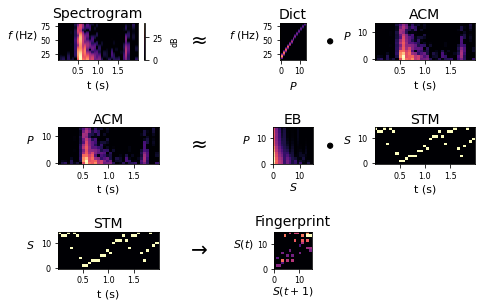

In [21]:
plt.rcParams.update({'font.size': 8})

LFS=11
tpad = 4
tfont=14

evID = cat00.event_ID.iloc[loc_ids[1]]

fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(3,8)
gs.update(wspace=.1, hspace=1.8)



ax = plt.subplot(gs[0,0:2])
specMat,x = getSgram(path_proj,evID,station)
figureFunctions2.plotSgram(specMat,evID,tSTFT,fSTFT,ax=ax)
ax.set_title('Spectrogram',pad=tpad+1,fontsize=tfont)
ax.set_ylabel('$f$ (Hz)',rotation=0,labelpad=18,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)


ax = plt.subplot(gs[0,4])
ax.set_title('Dict',pad=tpad,fontsize=tfont)
figureFunctions2.plotW(W_new,numPatterns,fSTFT,aspect=.3,ax=ax)
ax.set_ylabel('$f$ (Hz)',rotation=0,labelpad=18,fontsize=LFS)
ax.set_xlabel('$P$',fontsize=LFS)


ax = plt.subplot(gs[0,6:8])
ax.set_title('ACM',pad=tpad,fontsize=tfont)
figureFunctions2.plotACM(evID, pathACM, order_swap,tSTFT,numPatterns,ax=ax)
ax.set_ylabel('$P$',rotation=0,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)


ax = plt.subplot(gs[1,0:2])
ax.set_title('ACM',pad=tpad,fontsize=tfont)
figureFunctions2.plotACM(evID, pathACM, order_swap,tSTFT,numPatterns,ax=ax)
ax.set_ylabel('$P$',rotation=0,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)




ax = plt.subplot(gs[1,4])
figureFunctions2.plotEB(EB_new,aspect=1,ax=ax)
ax.set_title('EB',pad=tpad,fontsize=tfont)
ax.set_xlabel('$S$',labelpad=0,fontsize=LFS)
ax.set_ylabel('$P$',rotation=0,labelpad=10,fontsize=LFS)




ax = plt.subplot(gs[1,6:8])
figureFunctions2.plotSTM(evID, pathSTM,tSTFT,ax=ax)
ax.set_title('STM',pad=tpad,fontsize=tfont)
ax.set_ylabel('$S$',rotation=0,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)
                 
ax = plt.subplot(gs[2,0:2])
ax.set_title('STM',pad=tpad,fontsize=tfont)
figureFunctions2.plotSTM(evID, pathSTM,tSTFT,ax=ax)
ax.set_ylabel('$S$',rotation=0,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)



#### plot math symbols ###

ax = plt.subplot(gs[0,5])
circle1 = plt.Circle((0.08, 0.5), 0.07, color='k')
ax.add_patch(circle1)
ax.set_aspect('equal')
ax.axis('off')


ax = plt.subplot(gs[1,5])
circle1 = plt.Circle((0.08, 0.5), 0.07, color='k')
ax.add_patch(circle1)
ax.set_aspect('equal')
ax.axis('off')


ax = plt.subplot(gs[0,2])
ax.text(.5,.4,r'$\approx$',fontsize=20)
ax.axis('off')

ax = plt.subplot(gs[1,2])
ax.text(.5,.4,r'$\approx$',fontsize=20)
ax.axis('off')


ax = plt.subplot(gs[2,2])
ax.text(.5,.4,r'$\rightarrow$',fontsize=20)
ax.axis('off')



## plot FP
ax = plt.subplot(gs[2,4])
ax.set_title('Fingerprint',pad=tpad+2,fontsize=tfont)
figureFunctions2.plotFP(path_proj,outfile_name,evID,ax=ax)
ax.set_aspect('equal')
ax.set_ylabel('$S(t)$',rotation=0,labelpad=14,fontsize=LFS)
ax.set_xlabel('$S(t+1)}$',rotation=0,labelpad=0,fontsize=LFS)
# plt.tight_layout()
plt.savefig(pathFig + f'Figure_4.png',bbox_inches='tight')